In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle


In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    my_seed = 42,
                    TIME = 8,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on
                  ):
    # 함수 내 모든 로컬 변수 저장
    hyperparameters = locals()
    hyperparameters['top_train_acc_one_iter'] = 0
    hyperparameters['top_val_acc'] = 0
    hyperparameters['current epoch'] = 0

    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices

    
    torch.manual_seed(my_seed)


    
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on)
    synapse_fc_out_features = CLASS_NUM


    ## parameter number calculator ##########################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ## parameter number calculator ##########################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net)
    else:
        net = torch.load(pre_trained_path)


    net = net.to(device)
    if (net_print == True):
        print(net)
    
    ## param num and memory estimation except BN at MY calculation ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##########################################################################

    criterion = nn.CrossEntropyLoss().to(device)
    
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler

    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    train_acc_array = np.array([])
    val_acc_now_array = np.array([])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0

        if (domain_il_epoch>0 and which_data == 'PMNIST'):
            k = epoch // domain_il_epoch
            xtrain=data[k]['train']['x']
            ytrain=data[k]['train']['y']
            xtest =data[k]['test']['x']
            ytest =data[k]['test']['y']

        
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)

        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train()

            ## data loading #################################
            inputs, labels = data

            
            if (which_data == 'DVS_CIFAR10'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ################################################# 

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width]   
            # print(inputs.size())
            outputs = net(inputs)

            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)

            


            ####### training accruacy print ###############################
            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted[0:batch] == labels).sum().item()
            train_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * train_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            training_acc_string = f'{epoch}-{i}/{len(train_loader)} tr_acc: {100 * correct / total:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            

            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()


            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            
            optimizer.step()

            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##############################################
            if i % validation_interval == validation_interval-1:
                iter_one_val_time_start = time.time()
                
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval()
                    for data in test_loader:
                        ## data loading #################################
                        inputs, labels = data

                        
                        if (which_data == 'DVS_CIFAR10'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ################################################# 

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), "net_save/save_now_net_weights.pth")
                    torch.save(net, "net_save/save_now_net.pth")
                    torch.save(net.module.state_dict(), "net_save/save_now_net_weights2.pth")
                    torch.save(net.module, "net_save/save_now_net2.pth")
            ################################################################
            iterator.set_description(f"train: {training_acc_string}, tr_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  

            train_acc_array = np.append(train_acc_array, train_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
            val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
            hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

            if(train_acc > hyperparameters['top_train_acc_one_iter']):
                hyperparameters['top_train_acc_one_iter'] = train_acc
            if(val_acc_now > hyperparameters['top_val_acc']):
                hyperparameters['top_val_acc'] = val_acc_now
            hyperparameters['current epoch'] = epoch

            # 덮어쓰기 하기 싫으면 주석 풀어서 사용
            # np.save(train_acc_file_name, train_acc_array)
            # np.save(val_acc_file_name, val_acc_now_array)
            # with open(hyperparameters_file_name, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)

            np.save('result_save/train_acc_array.npy', train_acc_array)
            np.save('result_save/val_acc_now_array.npy', val_acc_now_array)
            with open('result_save/hyperparameters.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
            
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        
        epoch_time_end = time.time()
        epoch_time = epoch_time_end - epoch_start_time  # 실행 시간 계산
        
        print(f"epoch_time: {epoch_time} seconds")
        print('\n')


In [5]:
### my_snn control board ########################
decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

my_snn_system(  devices = "0,1,2,3,4,5",
                my_seed = 42,
                TIME = 10, # dvscifar 10 # ottt 6 or 10 # nda 10
                BATCH = 256, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 48, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS_CIFAR10',# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = True, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 0.5, #nda 0.5  #ottt 1.0 # 10000이상으로 하면 NDA LIF 씀.
                lif_layer_v_reset = 0.0, #현재 안씀. 걍 빼기 해버림
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # 10000 이상은 separable, 20000이상은 depthwise
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [64], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                pre_trained_path = "net_save/save_now_net.pth",
                learning_rate = 0.001, # default 0.001  # ottt 0.1  # nda 0.001
                epoch_num = 200,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐
                validation_interval = 36, #숫자 크게 하면 꺼짐
                tdBN_on = True,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'rough_rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = True,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'Adam', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling이 낫다.

# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


DataParallel(
  (module): MY_SNN_CONV(
    (layers): Sequential(
      (0): SYNAPSE_CONV_BPTT()
      (1): tdBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LIF_layer()
      (3): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (4): SYNAPSE_CONV_BPTT()
      (5): tdBatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LIF_layer()
      (7): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (8): SYNAPSE_CONV_BPTT()
      (9): tdBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LIF_layer()
      (11): SYNAPSE_CONV_BPTT()
      (12): tdBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): LIF_layer()
      (14): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (15): SY

train: 0-35/36 tr_acc: 40.00%, lr=['0.001'], tr_loss: 1.753957748413086, val_acc: 32.80%: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]

epoch_time: 34.83935213088989 seconds


EPOCH 1



train: 1-35/36 tr_acc: 25.00%, lr=['0.0009999383162408303'], tr_loss: 1.8648834228515625, val_acc: 27.40%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.955790996551514 seconds


EPOCH 2



train: 2-35/36 tr_acc: 25.00%, lr=['0.0009997532801828658'], tr_loss: 1.9010658264160156, val_acc: 33.80%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]

epoch_time: 18.661274433135986 seconds


EPOCH 3



train: 3-35/36 tr_acc: 40.00%, lr=['0.0009994449374809851'], tr_loss: 1.662292242050171, val_acc: 40.80%: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s] 

epoch_time: 18.729506492614746 seconds


EPOCH 4



train: 4-35/36 tr_acc: 50.00%, lr=['0.0009990133642141358'], tr_loss: 1.5700814723968506, val_acc: 39.70%: 100%|██████████| 36/36 [00:17<00:00,  2.00it/s]

epoch_time: 18.156789779663086 seconds


EPOCH 5



train: 5-35/36 tr_acc: 50.00%, lr=['0.000998458666866564'], tr_loss: 1.638048768043518, val_acc: 41.70%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s] 

epoch_time: 18.61236333847046 seconds


EPOCH 6



train: 6-35/36 tr_acc: 37.50%, lr=['0.00099778098230154'], tr_loss: 1.5589970350265503, val_acc: 39.80%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.966935873031616 seconds


EPOCH 7



train: 7-35/36 tr_acc: 42.50%, lr=['0.0009969804777275899'], tr_loss: 1.8248227834701538, val_acc: 44.90%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s]

epoch_time: 18.27944326400757 seconds


EPOCH 8



train: 8-35/36 tr_acc: 50.00%, lr=['0.000996057350657239'], tr_loss: 1.3206170797348022, val_acc: 44.50%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

epoch_time: 17.787400245666504 seconds


EPOCH 9



train: 9-35/36 tr_acc: 65.00%, lr=['0.0009950118288582787'], tr_loss: 1.1596288681030273, val_acc: 51.10%: 100%|██████████| 36/36 [00:17<00:00,  2.00it/s]

epoch_time: 18.18390154838562 seconds


EPOCH 10



train: 10-35/36 tr_acc: 57.50%, lr=['0.0009938441702975688'], tr_loss: 1.3093559741973877, val_acc: 26.70%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

epoch_time: 17.856270790100098 seconds


EPOCH 11



train: 11-35/36 tr_acc: 55.00%, lr=['0.000992554663077387'], tr_loss: 1.3125998973846436, val_acc: 52.70%: 100%|██████████| 36/36 [00:17<00:00,  2.00it/s]

epoch_time: 18.167813062667847 seconds


EPOCH 12



train: 12-35/36 tr_acc: 45.00%, lr=['0.0009911436253643444'], tr_loss: 1.277535080909729, val_acc: 49.00%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s] 

epoch_time: 17.7728374004364 seconds


EPOCH 13



train: 13-35/36 tr_acc: 55.00%, lr=['0.0009896114053108828'], tr_loss: 1.4777886867523193, val_acc: 48.30%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

epoch_time: 17.79187297821045 seconds


EPOCH 14



train: 14-35/36 tr_acc: 52.50%, lr=['0.0009879583809693736'], tr_loss: 1.39069664478302, val_acc: 49.70%: 100%|██████████| 36/36 [00:17<00:00,  2.01it/s]  

epoch_time: 18.089566469192505 seconds


EPOCH 15



train: 15-35/36 tr_acc: 70.00%, lr=['0.0009861849601988382'], tr_loss: 1.0245362520217896, val_acc: 38.90%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

epoch_time: 17.800864219665527 seconds


EPOCH 16



train: 16-35/36 tr_acc: 62.50%, lr=['0.0009842915805643154'], tr_loss: 1.1689496040344238, val_acc: 51.30%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

epoch_time: 17.849931716918945 seconds


EPOCH 17



train: 17-35/36 tr_acc: 62.50%, lr=['0.000982278709228899'], tr_loss: 1.1813867092132568, val_acc: 54.20%: 100%|██████████| 36/36 [00:18<00:00,  2.00it/s]

epoch_time: 18.22982883453369 seconds


EPOCH 18



train: 18-35/36 tr_acc: 65.00%, lr=['0.0009801468428384714'], tr_loss: 1.0533878803253174, val_acc: 49.30%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

epoch_time: 17.854742288589478 seconds


EPOCH 19



train: 19-35/36 tr_acc: 50.00%, lr=['0.0009778965073991648'], tr_loss: 1.3518346548080444, val_acc: 52.20%: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s]

epoch_time: 17.96234130859375 seconds


EPOCH 20



train: 20-35/36 tr_acc: 65.00%, lr=['0.0009755282581475766'], tr_loss: 0.8703809976577759, val_acc: 51.20%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

epoch_time: 17.875274658203125 seconds


EPOCH 21



train: 21-35/36 tr_acc: 60.00%, lr=['0.0009730426794137723'], tr_loss: 1.2222316265106201, val_acc: 49.20%: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s]

epoch_time: 18.031468152999878 seconds


EPOCH 22



train: 22-35/36 tr_acc: 67.50%, lr=['0.0009704403844771124'], tr_loss: 0.857296347618103, val_acc: 54.40%: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s] 

epoch_time: 18.37009859085083 seconds


EPOCH 23



train: 23-35/36 tr_acc: 67.50%, lr=['0.0009677220154149334'], tr_loss: 0.9339766502380371, val_acc: 61.70%: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s]

epoch_time: 18.404911041259766 seconds


EPOCH 24



train: 24-35/36 tr_acc: 55.00%, lr=['0.0009648882429441253'], tr_loss: 1.3133820295333862, val_acc: 55.60%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

epoch_time: 17.821001291275024 seconds


EPOCH 25



train: 25-35/36 tr_acc: 80.00%, lr=['0.000961939766255643'], tr_loss: 0.6497101783752441, val_acc: 58.50%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.9067542552948 seconds


EPOCH 26



train: 26-35/36 tr_acc: 67.50%, lr=['0.0009588773128419901'], tr_loss: 0.868090808391571, val_acc: 47.60%: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s] 

epoch_time: 17.99210023880005 seconds


EPOCH 27



train: 27-35/36 tr_acc: 67.50%, lr=['0.0009557016383177221'], tr_loss: 1.0262672901153564, val_acc: 57.60%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

epoch_time: 17.781111240386963 seconds


EPOCH 28



train: 28-35/36 tr_acc: 75.00%, lr=['0.0009524135262330093'], tr_loss: 1.0235750675201416, val_acc: 49.10%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s]

epoch_time: 17.745105981826782 seconds


EPOCH 29



train: 29-35/36 tr_acc: 67.50%, lr=['0.0009490137878803073'], tr_loss: 0.7081040143966675, val_acc: 41.50%: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s]

epoch_time: 17.988219022750854 seconds


EPOCH 30



train: 30-35/36 tr_acc: 72.50%, lr=['0.0009455032620941834'], tr_loss: 0.8461050987243652, val_acc: 56.00%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

epoch_time: 17.785645484924316 seconds


EPOCH 31



train: 31-35/36 tr_acc: 77.50%, lr=['0.0009418828150443463'], tr_loss: 0.6943033933639526, val_acc: 50.30%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.91770577430725 seconds


EPOCH 32



train: 32-35/36 tr_acc: 72.50%, lr=['0.0009381533400219311'], tr_loss: 0.6055663824081421, val_acc: 53.00%: 100%|██████████| 36/36 [00:17<00:00,  2.00it/s]

epoch_time: 18.164533615112305 seconds


EPOCH 33



train: 33-35/36 tr_acc: 77.50%, lr=['0.0009343157572190951'], tr_loss: 0.8037747144699097, val_acc: 52.30%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.965778589248657 seconds


EPOCH 34



train: 34-35/36 tr_acc: 75.00%, lr=['0.0009303710135019713'], tr_loss: 0.6755999326705933, val_acc: 52.10%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s] 

epoch_time: 17.76086163520813 seconds


EPOCH 35



train: 35-35/36 tr_acc: 72.50%, lr=['0.0009263200821770456'], tr_loss: 0.651369571685791, val_acc: 55.80%: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s]  

epoch_time: 18.01520586013794 seconds


EPOCH 36



train: 36-35/36 tr_acc: 85.00%, lr=['0.000922163962751007'], tr_loss: 0.47604554891586304, val_acc: 54.40%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.888240337371826 seconds


EPOCH 37



train: 37-35/36 tr_acc: 72.50%, lr=['0.0009179036806841347'], tr_loss: 0.7425233125686646, val_acc: 54.70%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.823053121566772 seconds


EPOCH 38



train: 38-35/36 tr_acc: 75.00%, lr=['0.0009135402871372803'], tr_loss: 0.9352928996086121, val_acc: 54.90%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s] 

epoch_time: 17.70205855369568 seconds


EPOCH 39



train: 39-35/36 tr_acc: 75.00%, lr=['0.0009090748587125112'], tr_loss: 0.636408805847168, val_acc: 53.20%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]  

epoch_time: 17.98814558982849 seconds


EPOCH 40



train: 40-35/36 tr_acc: 85.00%, lr=['0.0009045084971874732'], tr_loss: 0.5348812937736511, val_acc: 64.50%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s] 

epoch_time: 18.335597038269043 seconds


EPOCH 41



train: 41-35/36 tr_acc: 82.50%, lr=['0.0008998423292435448'], tr_loss: 0.6019087433815002, val_acc: 62.50%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s] 

epoch_time: 17.88857102394104 seconds


EPOCH 42



train: 42-35/36 tr_acc: 77.50%, lr=['0.0008950775061878446'], tr_loss: 0.6684074401855469, val_acc: 62.80%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s] 

epoch_time: 17.778627634048462 seconds


EPOCH 43



train: 43-35/36 tr_acc: 70.00%, lr=['0.0008902152036691643'], tr_loss: 0.8096576929092407, val_acc: 56.30%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s] 

epoch_time: 17.898298025131226 seconds


EPOCH 44



train: 44-35/36 tr_acc: 77.50%, lr=['0.000885256621387894'], tr_loss: 0.6385629177093506, val_acc: 55.10%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s] 

epoch_time: 17.926963567733765 seconds


EPOCH 45



train: 45-35/36 tr_acc: 77.50%, lr=['0.0008802029828000149'], tr_loss: 0.748325765132904, val_acc: 59.10%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]  

epoch_time: 17.92771339416504 seconds


EPOCH 46



train: 46-35/36 tr_acc: 85.00%, lr=['0.0008750555348152292'], tr_loss: 0.4924194812774658, val_acc: 56.90%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s] 

epoch_time: 17.822824001312256 seconds


EPOCH 47



train: 47-35/36 tr_acc: 75.00%, lr=['0.0008698155474893041'], tr_loss: 0.7091783285140991, val_acc: 57.00%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s] 

epoch_time: 17.79060935974121 seconds


EPOCH 48



train: 48-35/36 tr_acc: 82.50%, lr=['0.0008644843137107051'], tr_loss: 0.4994691014289856, val_acc: 65.30%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s] 

epoch_time: 18.565419912338257 seconds


EPOCH 49



train: 49-35/36 tr_acc: 82.50%, lr=['0.0008590631488815938'], tr_loss: 0.49599117040634155, val_acc: 57.30%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s]

epoch_time: 17.69927668571472 seconds


EPOCH 50



train: 50-35/36 tr_acc: 65.00%, lr=['0.0008535533905932731'], tr_loss: 0.8624647855758667, val_acc: 55.20%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s] 

epoch_time: 17.694615125656128 seconds


EPOCH 51



train: 51-35/36 tr_acc: 87.50%, lr=['0.0008479563982961564'], tr_loss: 0.33012062311172485, val_acc: 61.10%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.88517451286316 seconds


EPOCH 52



train: 52-35/36 tr_acc: 92.50%, lr=['0.0008422735529643437'], tr_loss: 0.3799229562282562, val_acc: 56.20%: 100%|██████████| 36/36 [00:17<00:00,  2.01it/s] 

epoch_time: 18.094390869140625 seconds


EPOCH 53



train: 53-35/36 tr_acc: 82.50%, lr=['0.000836506256754886'], tr_loss: 0.47155219316482544, val_acc: 59.70%: 100%|██████████| 36/36 [00:17<00:00,  2.01it/s]

epoch_time: 18.162238121032715 seconds


EPOCH 54



train: 54-35/36 tr_acc: 80.00%, lr=['0.0008306559326618253'], tr_loss: 0.7531291246414185, val_acc: 60.10%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s] 

epoch_time: 17.785791397094727 seconds


EPOCH 55



train: 55-35/36 tr_acc: 72.50%, lr=['0.0008247240241650912'], tr_loss: 0.9272093772888184, val_acc: 54.00%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.878185272216797 seconds


EPOCH 56



train: 56-35/36 tr_acc: 75.00%, lr=['0.0008187119948743442'], tr_loss: 0.61515212059021, val_acc: 59.50%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]   

epoch_time: 17.881816148757935 seconds


EPOCH 57



train: 57-35/36 tr_acc: 87.50%, lr=['0.000812621328167852'], tr_loss: 0.4079893231391907, val_acc: 62.10%: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s] 

epoch_time: 18.0411696434021 seconds


EPOCH 58



train: 58-35/36 tr_acc: 77.50%, lr=['0.0008064535268264877'], tr_loss: 0.5755608081817627, val_acc: 62.30%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s] 

epoch_time: 17.697075128555298 seconds


EPOCH 59



train: 59-35/36 tr_acc: 85.00%, lr=['0.0008002101126629415'], tr_loss: 0.3569997251033783, val_acc: 66.40%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s] 

epoch_time: 18.626171827316284 seconds


EPOCH 60



train: 60-35/36 tr_acc: 92.50%, lr=['0.000793892626146236'], tr_loss: 0.3879542350769043, val_acc: 59.60%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.83193588256836 seconds


EPOCH 61



train: 61-35/36 tr_acc: 85.00%, lr=['0.0007875026260216388'], tr_loss: 0.4719389081001282, val_acc: 67.00%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s] 

epoch_time: 18.595786333084106 seconds


EPOCH 62



train: 62-35/36 tr_acc: 77.50%, lr=['0.0007810416889260649'], tr_loss: 0.5310913920402527, val_acc: 61.20%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.812124967575073 seconds


EPOCH 63



train: 63-35/36 tr_acc: 90.00%, lr=['0.0007745114089990654'], tr_loss: 0.3885985016822815, val_acc: 60.90%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.865907907485962 seconds


EPOCH 64



train: 64-35/36 tr_acc: 95.00%, lr=['0.0007679133974894978'], tr_loss: 0.20255453884601593, val_acc: 58.50%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

epoch_time: 17.861269235610962 seconds


EPOCH 65



train: 65-35/36 tr_acc: 90.00%, lr=['0.0007612492823579739'], tr_loss: 0.37103062868118286, val_acc: 63.30%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.92668604850769 seconds


EPOCH 66



train: 66-35/36 tr_acc: 85.00%, lr=['0.0007545207078751852'], tr_loss: 0.3679003119468689, val_acc: 62.70%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s] 

epoch_time: 17.810755014419556 seconds


EPOCH 67



train: 67-35/36 tr_acc: 87.50%, lr=['0.0007477293342162034'], tr_loss: 0.42939692735671997, val_acc: 54.00%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

epoch_time: 17.812835454940796 seconds


EPOCH 68



train: 68-35/36 tr_acc: 85.00%, lr=['0.0007408768370508571'], tr_loss: 0.4269547462463379, val_acc: 61.00%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.881149768829346 seconds


EPOCH 69



train: 69-35/36 tr_acc: 77.50%, lr=['0.0007339649071302863'], tr_loss: 0.6490186452865601, val_acc: 59.70%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s] 

epoch_time: 17.68068027496338 seconds


EPOCH 70



train: 70-35/36 tr_acc: 92.50%, lr=['0.0007269952498697729'], tr_loss: 0.19092780351638794, val_acc: 60.60%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

epoch_time: 17.734948873519897 seconds


EPOCH 71



train: 71-35/36 tr_acc: 95.00%, lr=['0.000719969584927957'], tr_loss: 0.18895669281482697, val_acc: 62.40%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.935649156570435 seconds


EPOCH 72



train: 72-35/36 tr_acc: 82.50%, lr=['0.0007128896457825358'], tr_loss: 0.5927527546882629, val_acc: 64.70%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.827586889266968 seconds


EPOCH 73



train: 73-35/36 tr_acc: 70.00%, lr=['0.0007057571793025539'], tr_loss: 0.5400644540786743, val_acc: 63.70%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s] 

epoch_time: 17.962608575820923 seconds


EPOCH 74



train: 74-35/36 tr_acc: 87.50%, lr=['0.0006985739453173898'], tr_loss: 0.3469652533531189, val_acc: 62.30%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s] 

epoch_time: 17.765931367874146 seconds


EPOCH 75



train: 75-35/36 tr_acc: 87.50%, lr=['0.0006913417161825444'], tr_loss: 0.46898001432418823, val_acc: 64.60%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

epoch_time: 17.892499685287476 seconds


EPOCH 76



train: 76-35/36 tr_acc: 80.00%, lr=['0.0006840622763423385'], tr_loss: 0.5450111627578735, val_acc: 63.20%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s] 

epoch_time: 17.719608306884766 seconds


EPOCH 77



train: 77-35/36 tr_acc: 80.00%, lr=['0.000676737421889628'], tr_loss: 0.5734804272651672, val_acc: 58.20%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s] 

epoch_time: 17.913511514663696 seconds


EPOCH 78



train: 78-35/36 tr_acc: 90.00%, lr=['0.0006693689601226452'], tr_loss: 0.40321382880210876, val_acc: 62.40%: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s]

epoch_time: 17.99267053604126 seconds


EPOCH 79



train: 79-35/36 tr_acc: 80.00%, lr=['0.0006619587090990741'], tr_loss: 0.5268456339836121, val_acc: 62.90%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s] 

epoch_time: 17.70098328590393 seconds


EPOCH 80



train: 80-35/36 tr_acc: 80.00%, lr=['0.0006545084971874731'], tr_loss: 0.40240031480789185, val_acc: 62.50%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.907603979110718 seconds


EPOCH 81



train: 81-35/36 tr_acc: 85.00%, lr=['0.0006470201626161514'], tr_loss: 0.43743768334388733, val_acc: 62.20%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

epoch_time: 17.818761110305786 seconds


EPOCH 82



train: 82-35/36 tr_acc: 77.50%, lr=['0.0006394955530196142'], tr_loss: 0.4622410833835602, val_acc: 67.50%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s] 

epoch_time: 18.434914112091064 seconds


EPOCH 83



train: 83-35/36 tr_acc: 92.50%, lr=['0.0006319365249826858'], tr_loss: 0.19389285147190094, val_acc: 65.80%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

epoch_time: 17.768697500228882 seconds


EPOCH 84



train: 84-35/36 tr_acc: 85.00%, lr=['0.0006243449435824268'], tr_loss: 0.5388302803039551, val_acc: 53.40%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s] 

epoch_time: 17.687659978866577 seconds


EPOCH 85



train: 85-35/36 tr_acc: 90.00%, lr=['0.0006167226819279523'], tr_loss: 0.21060743927955627, val_acc: 65.10%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.950786590576172 seconds


EPOCH 86



train: 86-35/36 tr_acc: 85.00%, lr=['0.0006090716206982709'], tr_loss: 0.29949742555618286, val_acc: 60.60%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.95301055908203 seconds


EPOCH 87



train: 87-35/36 tr_acc: 85.00%, lr=['0.0006013936476782558'], tr_loss: 0.4351993203163147, val_acc: 66.10%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s] 

epoch_time: 17.929590225219727 seconds


EPOCH 88



train: 88-35/36 tr_acc: 92.50%, lr=['0.000593690657292862'], tr_loss: 0.23639395833015442, val_acc: 65.70%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

epoch_time: 17.775795936584473 seconds


EPOCH 89



train: 89-35/36 tr_acc: 90.00%, lr=['0.0005859645501397043'], tr_loss: 0.4273739457130432, val_acc: 64.60%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.857820510864258 seconds


EPOCH 90



train: 90-35/36 tr_acc: 95.00%, lr=['0.000578217232520115'], tr_loss: 0.1481403261423111, val_acc: 58.30%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s] 

epoch_time: 17.931142568588257 seconds


EPOCH 91



train: 91-35/36 tr_acc: 92.50%, lr=['0.000570450615968791'], tr_loss: 0.3129556179046631, val_acc: 61.50%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s] 

epoch_time: 17.920137882232666 seconds


EPOCH 92



train: 92-35/36 tr_acc: 95.00%, lr=['0.0005626666167821518'], tr_loss: 0.11595951020717621, val_acc: 66.60%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.93240761756897 seconds


EPOCH 93



train: 93-35/36 tr_acc: 95.00%, lr=['0.0005548671555455222'], tr_loss: 0.14289946854114532, val_acc: 65.50%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

epoch_time: 17.7075252532959 seconds


EPOCH 94



train: 94-35/36 tr_acc: 90.00%, lr=['0.0005470541566592567'], tr_loss: 0.28616413474082947, val_acc: 60.60%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.918630123138428 seconds


EPOCH 95



train: 95-35/36 tr_acc: 80.00%, lr=['0.000539229547863922'], tr_loss: 0.4186234474182129, val_acc: 63.00%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s] 

epoch_time: 17.79133367538452 seconds


EPOCH 96



train: 96-35/36 tr_acc: 87.50%, lr=['0.0005313952597646562'], tr_loss: 0.44375938177108765, val_acc: 66.60%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s]

epoch_time: 17.686625957489014 seconds


EPOCH 97



train: 97-35/36 tr_acc: 87.50%, lr=['0.0005235532253548208'], tr_loss: 0.3127641975879669, val_acc: 66.40%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.8207004070282 seconds


EPOCH 98



train: 98-35/36 tr_acc: 92.50%, lr=['0.0005157053795390637'], tr_loss: 0.18579097092151642, val_acc: 67.60%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s]

epoch_time: 18.47335720062256 seconds


EPOCH 99



train: 99-35/36 tr_acc: 100.00%, lr=['0.0005078536586559099'], tr_loss: 0.06472396105527878, val_acc: 66.20%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

epoch_time: 17.763036251068115 seconds


EPOCH 100



train: 100-35/36 tr_acc: 92.50%, lr=['0.0004999999999999996'], tr_loss: 0.23197677731513977, val_acc: 65.20%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

epoch_time: 17.759066343307495 seconds


EPOCH 101



train: 101-35/36 tr_acc: 87.50%, lr=['0.0004921463413440893'], tr_loss: 0.4532701373100281, val_acc: 67.60%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.894720792770386 seconds


EPOCH 102



train: 102-35/36 tr_acc: 97.50%, lr=['0.0004842946204609354'], tr_loss: 0.19610485434532166, val_acc: 67.10%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.83321213722229 seconds


EPOCH 103



train: 103-35/36 tr_acc: 90.00%, lr=['0.00047644677464517824'], tr_loss: 0.32764536142349243, val_acc: 63.60%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]

epoch_time: 17.953820943832397 seconds


EPOCH 104



train: 104-35/36 tr_acc: 90.00%, lr=['0.00046860474023534287'], tr_loss: 0.29079777002334595, val_acc: 67.10%: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s]

epoch_time: 18.011303424835205 seconds


EPOCH 105



train: 105-35/36 tr_acc: 87.50%, lr=['0.00046077045213607716'], tr_loss: 0.388592004776001, val_acc: 62.00%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]  

epoch_time: 17.764887809753418 seconds


EPOCH 106



train: 106-35/36 tr_acc: 90.00%, lr=['0.0004529458433407424'], tr_loss: 0.27470657229423523, val_acc: 67.20%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

epoch_time: 17.90669345855713 seconds


EPOCH 107



train: 107-35/36 tr_acc: 95.00%, lr=['0.000445132844454477'], tr_loss: 0.24447298049926758, val_acc: 58.40%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s]

epoch_time: 17.675135612487793 seconds


EPOCH 108



train: 108-35/36 tr_acc: 85.00%, lr=['0.0004373333832178475'], tr_loss: 0.5454607605934143, val_acc: 66.40%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.82675838470459 seconds


EPOCH 109



train: 109-35/36 tr_acc: 95.00%, lr=['0.0004295493840312084'], tr_loss: 0.2315473109483719, val_acc: 63.50%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s] 

epoch_time: 17.931660652160645 seconds


EPOCH 110



train: 110-35/36 tr_acc: 87.50%, lr=['0.0004217827674798842'], tr_loss: 0.2944648265838623, val_acc: 63.60%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]  

epoch_time: 17.731441736221313 seconds


EPOCH 111



train: 111-35/36 tr_acc: 92.50%, lr=['0.00041403544986029484'], tr_loss: 0.26847800612449646, val_acc: 63.20%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.827927589416504 seconds


EPOCH 112



train: 112-35/36 tr_acc: 87.50%, lr=['0.0004063093427071374'], tr_loss: 0.3763279914855957, val_acc: 66.00%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]  

epoch_time: 17.805631399154663 seconds


EPOCH 113



train: 113-35/36 tr_acc: 87.50%, lr=['0.00039860635232174353'], tr_loss: 0.4567789137363434, val_acc: 58.50%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s] 

epoch_time: 17.692421674728394 seconds


EPOCH 114



train: 114-35/36 tr_acc: 97.50%, lr=['0.0003909283793017286'], tr_loss: 0.08068932592868805, val_acc: 65.30%: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s] 

epoch_time: 17.922762870788574 seconds


EPOCH 115



train: 115-35/36 tr_acc: 87.50%, lr=['0.000383277318072047'], tr_loss: 0.2724763751029968, val_acc: 66.80%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]  

epoch_time: 17.860409259796143 seconds


EPOCH 116



train: 116-35/36 tr_acc: 95.00%, lr=['0.00037565505641757235'], tr_loss: 0.16571255028247833, val_acc: 66.80%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

epoch_time: 17.8744797706604 seconds


EPOCH 117



train: 117-35/36 tr_acc: 95.00%, lr=['0.0003680634750173133'], tr_loss: 0.24670962989330292, val_acc: 65.20%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s] 

epoch_time: 17.705321788787842 seconds


EPOCH 118



train: 118-35/36 tr_acc: 97.50%, lr=['0.00036050444698038515'], tr_loss: 0.07857413589954376, val_acc: 67.90%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s] 

epoch_time: 18.320783376693726 seconds


EPOCH 119



train: 119-35/36 tr_acc: 92.50%, lr=['0.0003529798373838478'], tr_loss: 0.17878630757331848, val_acc: 67.90%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.82399559020996 seconds


EPOCH 120



train: 120-35/36 tr_acc: 90.00%, lr=['0.0003454915028125262'], tr_loss: 0.34843218326568604, val_acc: 67.20%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s] 

epoch_time: 17.66014528274536 seconds


EPOCH 121



train: 121-35/36 tr_acc: 95.00%, lr=['0.00033804129090092506'], tr_loss: 0.21813900768756866, val_acc: 62.10%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.910149097442627 seconds


EPOCH 122



train: 122-35/36 tr_acc: 90.00%, lr=['0.0003306310398773541'], tr_loss: 0.19880317151546478, val_acc: 68.10%: 100%|██████████| 36/36 [00:18<00:00,  2.00it/s] 

epoch_time: 18.228434085845947 seconds


EPOCH 123



train: 123-35/36 tr_acc: 92.50%, lr=['0.00032326257811037126'], tr_loss: 0.29385045170783997, val_acc: 67.70%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s] 

epoch_time: 18.53523302078247 seconds


EPOCH 124



train: 124-35/36 tr_acc: 90.00%, lr=['0.0003159377236576609'], tr_loss: 0.19033357501029968, val_acc: 68.20%: 100%|██████████| 36/36 [00:21<00:00,  1.65it/s] 

epoch_time: 22.06758975982666 seconds


EPOCH 125



train: 125-35/36 tr_acc: 97.50%, lr=['0.000308658283817455'], tr_loss: 0.056276850402355194, val_acc: 68.60%: 100%|██████████| 36/36 [00:21<00:00,  1.69it/s] 

epoch_time: 21.54548978805542 seconds


EPOCH 126



train: 126-35/36 tr_acc: 95.00%, lr=['0.0003014260546826094'], tr_loss: 0.22829492390155792, val_acc: 67.00%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s] 

epoch_time: 17.721802711486816 seconds


EPOCH 127



train: 127-35/36 tr_acc: 95.00%, lr=['0.0002942428206974454'], tr_loss: 0.25933218002319336, val_acc: 67.00%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s] 

epoch_time: 17.752780437469482 seconds


EPOCH 128



train: 128-35/36 tr_acc: 95.00%, lr=['0.00028711035421746345'], tr_loss: 0.11300788819789886, val_acc: 66.80%: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s] 

epoch_time: 17.876096725463867 seconds


EPOCH 129



train: 129-35/36 tr_acc: 97.50%, lr=['0.0002800304150720422'], tr_loss: 0.07041991502046585, val_acc: 66.10%: 100%|██████████| 36/36 [00:22<00:00,  1.62it/s] 

epoch_time: 22.351970195770264 seconds


EPOCH 130



train: 130-35/36 tr_acc: 95.00%, lr=['0.0002730047501302264'], tr_loss: 0.13106703758239746, val_acc: 67.20%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s] 

epoch_time: 23.22713303565979 seconds


EPOCH 131



train: 131-35/36 tr_acc: 97.50%, lr=['0.0002660350928697132'], tr_loss: 0.11240885406732559, val_acc: 67.90%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]  

epoch_time: 23.051361083984375 seconds


EPOCH 132



train: 132-35/36 tr_acc: 97.50%, lr=['0.0002591231629491421'], tr_loss: 0.22606870532035828, val_acc: 68.60%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s] 

epoch_time: 22.99408769607544 seconds


EPOCH 133



train: 133-35/36 tr_acc: 95.00%, lr=['0.00025227066578379596'], tr_loss: 0.2309780865907669, val_acc: 67.70%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]   

epoch_time: 23.221517086029053 seconds


EPOCH 134



train: 134-35/36 tr_acc: 100.00%, lr=['0.0002454792921248141'], tr_loss: 0.10038688033819199, val_acc: 70.10%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

epoch_time: 23.807228565216064 seconds


EPOCH 135



train: 135-35/36 tr_acc: 95.00%, lr=['0.00023875071764202534'], tr_loss: 0.07487218081951141, val_acc: 68.50%: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]  

epoch_time: 22.70957922935486 seconds


EPOCH 136



train: 136-35/36 tr_acc: 90.00%, lr=['0.0002320866025105013'], tr_loss: 0.48117750883102417, val_acc: 68.30%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]  

epoch_time: 22.947227954864502 seconds


EPOCH 137



train: 137-35/36 tr_acc: 85.00%, lr=['0.0002254885910009338'], tr_loss: 0.5041996240615845, val_acc: 67.10%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]   

epoch_time: 23.280661821365356 seconds


EPOCH 138



train: 138-35/36 tr_acc: 95.00%, lr=['0.0002189583110739344'], tr_loss: 0.10689596831798553, val_acc: 65.00%: 100%|██████████| 36/36 [00:21<00:00,  1.64it/s] 

epoch_time: 22.160044193267822 seconds


EPOCH 139



train: 139-35/36 tr_acc: 97.50%, lr=['0.00021249737397836048'], tr_loss: 0.13004902005195618, val_acc: 69.70%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]  

epoch_time: 23.204322338104248 seconds


EPOCH 140



train: 140-35/36 tr_acc: 95.00%, lr=['0.00020610737385376327'], tr_loss: 0.19395846128463745, val_acc: 68.50%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.359556674957275 seconds


EPOCH 141



train: 141-35/36 tr_acc: 97.50%, lr=['0.00019978988733705783'], tr_loss: 0.09589875489473343, val_acc: 68.10%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.775577306747437 seconds


EPOCH 142



train: 142-35/36 tr_acc: 85.00%, lr=['0.00019354647317351147'], tr_loss: 0.5416852235794067, val_acc: 68.00%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]  

epoch_time: 24.42844557762146 seconds


EPOCH 143



train: 143-35/36 tr_acc: 95.00%, lr=['0.00018737867183214719'], tr_loss: 0.10809510946273804, val_acc: 67.20%: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s] 

epoch_time: 24.246105432510376 seconds


EPOCH 144



train: 144-35/36 tr_acc: 100.00%, lr=['0.0001812880051256549'], tr_loss: 0.04090317711234093, val_acc: 68.80%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s] 

epoch_time: 22.936851501464844 seconds


EPOCH 145



train: 145-35/36 tr_acc: 87.50%, lr=['0.00017527597583490801'], tr_loss: 0.3602142035961151, val_acc: 67.90%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]   

epoch_time: 23.130111694335938 seconds


EPOCH 146



train: 146-35/36 tr_acc: 95.00%, lr=['0.00016934406733817395'], tr_loss: 0.2034170925617218, val_acc: 69.30%: 100%|██████████| 36/36 [00:22<00:00,  1.61it/s]   

epoch_time: 22.54684281349182 seconds


EPOCH 147



train: 147-35/36 tr_acc: 90.00%, lr=['0.0001634937432451131'], tr_loss: 0.317301869392395, val_acc: 68.80%: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]    

epoch_time: 22.914287328720093 seconds


EPOCH 148



train: 148-35/36 tr_acc: 92.50%, lr=['0.00015772644703565544'], tr_loss: 0.20129962265491486, val_acc: 68.80%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]  

epoch_time: 23.04660701751709 seconds


EPOCH 149



train: 149-35/36 tr_acc: 97.50%, lr=['0.00015204360170384266'], tr_loss: 0.11431050300598145, val_acc: 67.50%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.354100942611694 seconds


EPOCH 150



train: 150-35/36 tr_acc: 97.50%, lr=['0.0001464466094067261'], tr_loss: 0.04797392338514328, val_acc: 68.10%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]  

epoch_time: 23.309857606887817 seconds


EPOCH 151



train: 151-35/36 tr_acc: 92.50%, lr=['0.00014093685111840547'], tr_loss: 0.13317175209522247, val_acc: 67.80%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.727793216705322 seconds


EPOCH 152



train: 152-35/36 tr_acc: 100.00%, lr=['0.00013551568628929414'], tr_loss: 0.011315373703837395, val_acc: 68.50%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]

epoch_time: 23.448301076889038 seconds


EPOCH 153



train: 153-35/36 tr_acc: 82.50%, lr=['0.00013018445251069492'], tr_loss: 0.4384607672691345, val_acc: 69.30%: 100%|██████████| 36/36 [00:22<00:00,  1.61it/s]   

epoch_time: 22.57046604156494 seconds


EPOCH 154



train: 154-35/36 tr_acc: 100.00%, lr=['0.00012494446518477003'], tr_loss: 0.033239975571632385, val_acc: 67.40%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]

epoch_time: 22.95306086540222 seconds


EPOCH 155



train: 155-35/36 tr_acc: 95.00%, lr=['0.00011979701719998438'], tr_loss: 0.1386345773935318, val_acc: 67.40%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]   

epoch_time: 23.473723649978638 seconds


EPOCH 156



train: 156-35/36 tr_acc: 95.00%, lr=['0.00011474337861210527'], tr_loss: 0.16756783425807953, val_acc: 67.30%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]  

epoch_time: 23.104969024658203 seconds


EPOCH 157



train: 157-35/36 tr_acc: 95.00%, lr=['0.00010978479633083506'], tr_loss: 0.19539900124073029, val_acc: 68.40%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]  

epoch_time: 23.025710821151733 seconds


EPOCH 158



train: 158-35/36 tr_acc: 87.50%, lr=['0.00010492249381215464'], tr_loss: 0.26388007402420044, val_acc: 69.20%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]  

epoch_time: 23.274604558944702 seconds


EPOCH 159



train: 159-35/36 tr_acc: 97.50%, lr=['0.00010015767075645457'], tr_loss: 0.07775194942951202, val_acc: 67.90%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]  

epoch_time: 23.277899026870728 seconds


EPOCH 160



train: 160-35/36 tr_acc: 100.00%, lr=['9.549150281252619e-05'], tr_loss: 0.019221816211938858, val_acc: 68.70%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]

epoch_time: 23.513636350631714 seconds


EPOCH 161



train: 161-35/36 tr_acc: 100.00%, lr=['9.092514128748822e-05'], tr_loss: 0.024466997012495995, val_acc: 69.60%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

epoch_time: 24.111103296279907 seconds


EPOCH 162



train: 162-35/36 tr_acc: 97.50%, lr=['8.645971286271902e-05'], tr_loss: 0.08648969978094101, val_acc: 68.60%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.731715440750122 seconds


EPOCH 163



train: 163-35/36 tr_acc: 92.50%, lr=['8.209631931586485e-05'], tr_loss: 0.11946862936019897, val_acc: 70.60%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]  

epoch_time: 23.225765705108643 seconds


EPOCH 164



train: 164-35/36 tr_acc: 100.00%, lr=['7.783603724899246e-05'], tr_loss: 0.06487578898668289, val_acc: 70.60%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s] 

epoch_time: 24.04681372642517 seconds


EPOCH 165



train: 165-35/36 tr_acc: 92.50%, lr=['7.367991782295392e-05'], tr_loss: 0.15577271580696106, val_acc: 69.20%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]  

epoch_time: 23.384581327438354 seconds


EPOCH 166



train: 166-35/36 tr_acc: 100.00%, lr=['6.962898649802802e-05'], tr_loss: 0.03240027278661728, val_acc: 68.60%: 100%|██████████| 36/36 [00:22<00:00,  1.63it/s] 

epoch_time: 22.231459856033325 seconds


EPOCH 167



train: 167-35/36 tr_acc: 95.00%, lr=['6.568424278090424e-05'], tr_loss: 0.14099319279193878, val_acc: 68.70%: 100%|██████████| 36/36 [00:22<00:00,  1.63it/s]   

epoch_time: 22.276421308517456 seconds


EPOCH 168



train: 168-35/36 tr_acc: 92.50%, lr=['6.184665997806812e-05'], tr_loss: 0.17258858680725098, val_acc: 69.10%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]  

epoch_time: 23.159480094909668 seconds


EPOCH 169



train: 169-35/36 tr_acc: 92.50%, lr=['5.811718495565318e-05'], tr_loss: 0.23565490543842316, val_acc: 68.80%: 100%|██████████| 36/36 [00:22<00:00,  1.62it/s]  

epoch_time: 22.4735324382782 seconds


EPOCH 170



train: 170-35/36 tr_acc: 92.50%, lr=['5.449673790581603e-05'], tr_loss: 0.10816417634487152, val_acc: 68.80%: 100%|██████████| 36/36 [00:22<00:00,  1.62it/s]   

epoch_time: 22.419461488723755 seconds


EPOCH 171



train: 171-35/36 tr_acc: 95.00%, lr=['5.098621211969216e-05'], tr_loss: 0.142226442694664, val_acc: 70.60%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]     

epoch_time: 23.40721869468689 seconds


EPOCH 172



train: 172-35/36 tr_acc: 90.00%, lr=['4.7586473766990253e-05'], tr_loss: 0.21135374903678894, val_acc: 68.70%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.719111919403076 seconds


EPOCH 173



train: 173-35/36 tr_acc: 100.00%, lr=['4.4298361682277405e-05'], tr_loss: 0.06891410052776337, val_acc: 69.90%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s] 

epoch_time: 23.17780303955078 seconds


EPOCH 174



train: 174-35/36 tr_acc: 95.00%, lr=['4.1122687158009486e-05'], tr_loss: 0.10291393101215363, val_acc: 68.20%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]   

epoch_time: 23.018319368362427 seconds


EPOCH 175



train: 175-35/36 tr_acc: 95.00%, lr=['3.8060233744356686e-05'], tr_loss: 0.10780321061611176, val_acc: 70.30%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]  

epoch_time: 23.04971146583557 seconds


EPOCH 176



train: 176-35/36 tr_acc: 100.00%, lr=['3.511175705587427e-05'], tr_loss: 0.039412952959537506, val_acc: 68.80%: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]

epoch_time: 22.885632276535034 seconds


EPOCH 177



train: 177-35/36 tr_acc: 97.50%, lr=['3.2277984585066264e-05'], tr_loss: 0.08015309274196625, val_acc: 69.50%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.547356367111206 seconds


EPOCH 178



train: 178-35/36 tr_acc: 97.50%, lr=['2.955961552288723e-05'], tr_loss: 0.12029429525136948, val_acc: 69.80%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.64228653907776 seconds


EPOCH 179



train: 179-35/36 tr_acc: 95.00%, lr=['2.6957320586227313e-05'], tr_loss: 0.11358165740966797, val_acc: 68.70%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]   

epoch_time: 23.424827337265015 seconds


EPOCH 180



train: 180-35/36 tr_acc: 95.00%, lr=['2.44717418524232e-05'], tr_loss: 0.24291399121284485, val_acc: 69.60%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]   

epoch_time: 24.060162782669067 seconds


EPOCH 181



train: 181-35/36 tr_acc: 97.50%, lr=['2.210349260083491e-05'], tr_loss: 0.08744264394044876, val_acc: 70.80%: 100%|██████████| 36/36 [00:24<00:00,  1.45it/s]  

epoch_time: 25.010324239730835 seconds


EPOCH 182



train: 182-35/36 tr_acc: 95.00%, lr=['1.9853157161528496e-05'], tr_loss: 0.21024258434772491, val_acc: 69.50%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.69272255897522 seconds


EPOCH 183



train: 183-35/36 tr_acc: 92.50%, lr=['1.7721290771100992e-05'], tr_loss: 0.3177952170372009, val_acc: 69.10%: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]    

epoch_time: 22.908082008361816 seconds


EPOCH 184



train: 184-35/36 tr_acc: 97.50%, lr=['1.5708419435684497e-05'], tr_loss: 0.20654678344726562, val_acc: 69.10%: 100%|██████████| 36/36 [00:22<00:00,  1.61it/s]   

epoch_time: 22.598653554916382 seconds


EPOCH 185



train: 185-35/36 tr_acc: 97.50%, lr=['1.3815039801161704e-05'], tr_loss: 0.13451503217220306, val_acc: 70.10%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]   

epoch_time: 23.08600664138794 seconds


EPOCH 186



train: 186-35/36 tr_acc: 95.00%, lr=['1.2041619030626323e-05'], tr_loss: 0.08619599789381027, val_acc: 69.50%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]   

epoch_time: 23.224144220352173 seconds


EPOCH 187



train: 187-35/36 tr_acc: 92.50%, lr=['1.0388594689117057e-05'], tr_loss: 0.17988692224025726, val_acc: 69.30%: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]   

epoch_time: 22.791857719421387 seconds


EPOCH 188



train: 188-35/36 tr_acc: 100.00%, lr=['8.856374635655629e-06'], tr_loss: 0.03602594882249832, val_acc: 69.60%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]  

epoch_time: 24.016722202301025 seconds


EPOCH 189



train: 189-35/36 tr_acc: 100.00%, lr=['7.445336922613057e-06'], tr_loss: 0.04933964088559151, val_acc: 70.10%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s] 

epoch_time: 23.227826595306396 seconds


EPOCH 190



train: 190-35/36 tr_acc: 95.00%, lr=['6.155829702431163e-06'], tr_loss: 0.1256372183561325, val_acc: 69.80%: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]    

epoch_time: 22.82801365852356 seconds


EPOCH 191



train: 191-35/36 tr_acc: 97.50%, lr=['4.988171141721226e-06'], tr_loss: 0.06435035169124603, val_acc: 69.20%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]   

epoch_time: 23.312494039535522 seconds


EPOCH 192



train: 192-35/36 tr_acc: 100.00%, lr=['3.942649342761113e-06'], tr_loss: 0.00466590141877532, val_acc: 69.50%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]  

epoch_time: 22.91685438156128 seconds


EPOCH 193



train: 193-35/36 tr_acc: 92.50%, lr=['3.0195222724101985e-06'], tr_loss: 0.1318991780281067, val_acc: 70.90%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]    

epoch_time: 23.904938220977783 seconds


EPOCH 194



train: 194-35/36 tr_acc: 95.00%, lr=['2.219017698459999e-06'], tr_loss: 0.1509203463792801, val_acc: 70.00%: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]    

epoch_time: 22.72398281097412 seconds


EPOCH 195



train: 195-35/36 tr_acc: 100.00%, lr=['1.5413331334360161e-06'], tr_loss: 0.020939508453011513, val_acc: 70.20%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 23.95352292060852 seconds


EPOCH 196



train: 196-35/36 tr_acc: 97.50%, lr=['9.866357858642194e-07'], tr_loss: 0.10426497459411621, val_acc: 69.30%: 100%|██████████| 36/36 [00:22<00:00,  1.62it/s]   

epoch_time: 22.49811577796936 seconds


EPOCH 197



train: 197-35/36 tr_acc: 95.00%, lr=['5.550625190150475e-07'], tr_loss: 0.13115593791007996, val_acc: 70.10%: 100%|██████████| 36/36 [00:22<00:00,  1.61it/s]   

epoch_time: 22.520934581756592 seconds


EPOCH 198



train: 198-35/36 tr_acc: 97.50%, lr=['2.4671981713419966e-07'], tr_loss: 0.10503388941287994, val_acc: 70.20%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]   

epoch_time: 23.342824935913086 seconds


EPOCH 199



train: 199-35/36 tr_acc: 100.00%, lr=['6.168375916970607e-08'], tr_loss: 0.03727557510137558, val_acc: 69.70%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.714062929153442 seconds




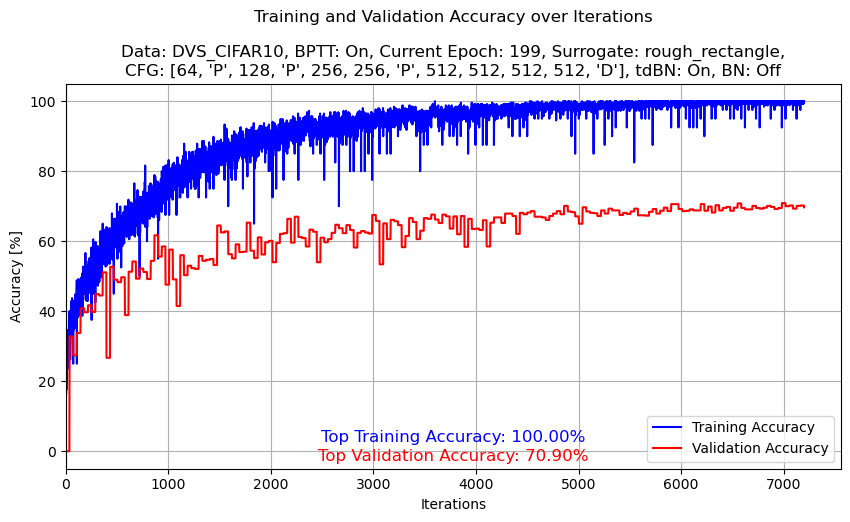

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename='hyperparameters.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

### if you want to just see most recent train and val acc###########################
train_acc_file_name = 'result_save/train_acc_array.npy'
val_acc_file_name = 'result_save/val_acc_now_array.npy'
hyperparameters_file_name = 'result_save/hyperparameters.json'

loaded_train_acc_array = np.load(train_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_train_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_train_acc_array, loaded_val_acc_array)
top_train_acc = hyperparameters['top_train_acc_one_iter']
top_val_acc = hyperparameters['top_val_acc']
which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
surrogate = hyperparameters['surrogate']
cfg = hyperparameters['cfg']
tdBN_on = hyperparameters['tdBN_on']
BN_on = hyperparameters['BN_on']


iterations = np.arange(len(loaded_train_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_train_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # 텍스트 추가
# plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_train_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# 텍스트 추가
plt.text(0.5, 0.10, f'Top Training Accuracy: {100*top_train_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
plt.text(0.5, 0.05, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()